In [1]:
from functools import partial

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('white')

In [3]:
import cv2

In [4]:
from sklearn.metrics import confusion_matrix

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import albumentations as A

In [6]:
train_folder_path = r'C:\Users\migue\OneDrive - Universitat de les Illes Balears\Proyectos\ZAP\FruitFlyNet\scripts\dataset\train'
test_folder_path = r'C:\Users\migue\OneDrive - Universitat de les Illes Balears\Proyectos\ZAP\FruitFlyNet\scripts\dataset\test'

ppp = r'C:\Users\migue\OneDrive - Universitat de les Illes Balears\Proyectos\ZAP\FruitFlyNet\scripts\dataset\train224'

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    ppp,
    validation_split=0.2,
    subset="training",
    image_size=(30, 30),
    batch_size=32,
    seed=689,
    label_mode='categorical'
)

Found 66 files belonging to 3 classes.
Using 53 files for training.


In [8]:
class_names = train_ds.class_names
print(class_names)

['black', 'fly', 'trap']


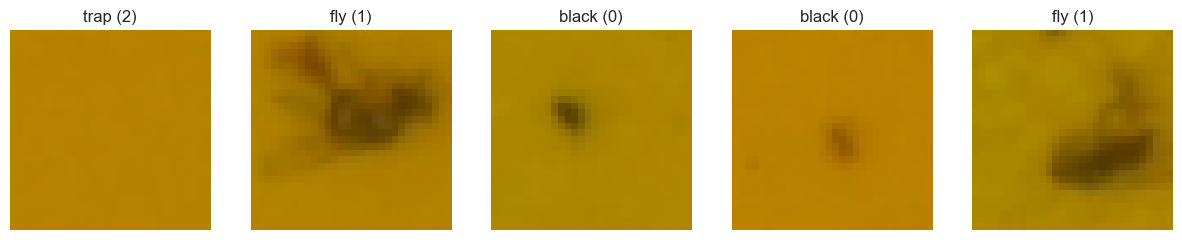

In [9]:
# Tomar los primeros 5 elementos del conjunto de datos
images, labels = next(iter(train_ds.take(5)))

# Crear una figura de 5 columnas y 1 fila para mostrar cada imagen
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

# Iterar sobre las imágenes y mostrar cada una en su propio eje
for i, ax in enumerate(axes):
    ax.imshow(np.array(images[i], dtype='uint8'))
    title = f'{class_names[np.argmax(labels[i])]} ({np.argmax(labels[i])})'
    ax.set_title(title)
    ax.axis('off')

# Mostrar la figura
plt.show()

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    ppp,
    validation_split=0.2,
    subset="validation",
    image_size=(30, 30),
    batch_size=32,
    seed=689,
    label_mode='categorical'
)

Found 66 files belonging to 3 classes.
Using 13 files for validation.


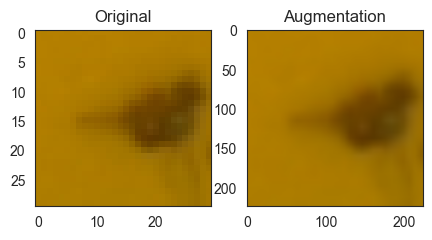

Transformaciones:
  · Resize: True
  · HorizontalFlip: False
  · VerticalFlip: False
  · RandomRotate90: False
  · RandomBrightnessContrast: False


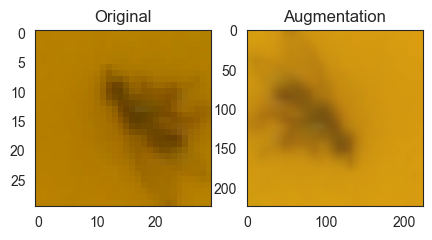

Transformaciones:
  · Resize: True
  · HorizontalFlip: False
  · VerticalFlip: False
  · RandomRotate90: True
  · RandomBrightnessContrast: True


In [11]:
import random
import os
from PIL import Image

transform = A.ReplayCompose([
    A.Resize(224, 224, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])

p = os.path.join(train_folder_path, 'fly')
files = os.listdir(p)
samples = 2
random_samples = random.sample(files, samples)

for i in range(samples):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 4))
    img_path = os.path.join(p, random_samples[i])
    img = Image.open(img_path)
    img_transf = np.array(img)
    img_transf = transform(image=img_transf)
    replay = img_transf['replay']
    img_transf = img_transf['image']
    axes[0].imshow(img)
    axes[0].set_title('Original')
    axes[1].imshow(img_transf)
    axes[1].set_title('Augmentation')
    plt.show()
    print('Transformaciones:')
    for r in replay['transforms']:  
        print(f"  · {r['__class_fullname__']}: {r['applied']}")

In [12]:
# Data augmentation

transform = A.Compose([
#     A.Resize(height=224, width=224, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize()
])

def aug_fn(image):
    data = {"image":image}
    aug_data = transform(**data)
    aug_img = aug_data["image"]
    return aug_img
    
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label

# create dataset
train_generator = train_ds.map(partial(process_data))



transform_val = A.Compose([
#     A.Resize(224, 224, always_apply=True),
    A.Normalize()
])

# Data augmentation
def aug_fn(image):
    data = {"image":image}
    aug_data = transform_val(**data)
    aug_img = aug_data["image"]
    return aug_img
    
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label

# create dataset
val_generator = val_ds.map(partial(process_data))

In [13]:
modelo_vgg16_no_top = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False)
modelo_vgg16_no_top.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
head_model = modelo_vgg16_no_top.output
head_model = Flatten()(head_model)
# head_model = Dense(512, activation='relu')(head_model)
head_model = Dense(len(class_names), activation='softmax')(head_model)

model = Model(inputs= modelo_vgg16_no_top.input, outputs=head_model)

for layer in modelo_vgg16_no_top.layers:
    layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
earlystopping = EarlyStopping(patience=5, verbose=1, mode="auto")
cp_callback = ModelCheckpoint(filepath='model_checkpoint_cp.h5', save_best_only=True, verbose=1)
tensorboard = TensorBoard()

In [17]:
history = model.fit(
            train_generator, 
            epochs=100, 
            validation_data=val_generator,
            callbacks=[earlystopping, cp_callback, tensorboard]
          )

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'model/dense/BiasAdd' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\migue\AppData\Local\Temp\ipykernel_26240\2931322036.py", line 1, in <module>
      history = model.fit(
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\migue\miniconda3\envs\mmr689\Lib\site-packages\keras\layers\core\dense.py", line 252, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'model/dense/BiasAdd'
Matrix size-incompatible: In[0]: [30,0], In[1]: [25088,3]
	 [[{{node model/dense/BiasAdd}}]] [Op:__inference_train_function_1517]

In [ ]:
val_labels = []
for batch_img, batch_lab in val_ds:
    for img, lab in zip(batch_img, batch_lab):
        im, la = np.array(img, dtype='uint8'), np.argmax(lab)
        val_labels.append(la)

In [ ]:
predictions = model.predict(val_generator)
predictions = predictions.argmax(axis=1)

In [ ]:
# Calcular la matriz de confusión en porcentaje
cm = confusion_matrix(np.array(val_labels), predictions)

# Creación del heatmap
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicción', fontsize=14)
ax.set_ylabel('Etiqueta verdadera', fontsize=14)
ax.set_title('Matriz de confusión', fontsize=16)
plt.show()